In [24]:
# import library
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM

In [25]:
#import dataset
data_train = pd.read_csv('DailyDelhiClimateTrain.csv')
data_train

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [26]:
#convert datetime
data_train.date = pd.to_datetime(data_train.date)

In [27]:
datatrain_new = data_train.drop(["meantemp", "humidity", "meanpressure"], axis=1)
datatrain_new

,date,wind_speed
0,2013-01-01,0.000000
1,2013-01-02,2.980000
2,2013-01-03,4.633333
3,2013-01-04,1.233333
4,2013-01-05,3.700000
...,...,...
1457,2016-12-28,3.547826
1458,2016-12-29,6.000000
1459,2016-12-30,6.266667
1460,2016-12-31,7.325000


Text(0.5, 1.0, 'Kecepatan Angin')

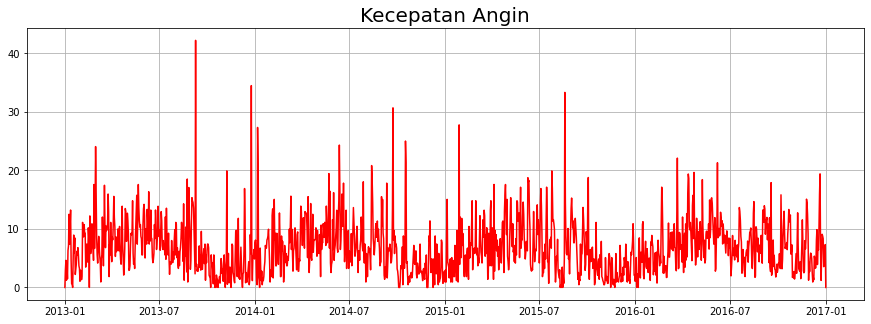

In [28]:
date = datatrain_new["date"].values
wind_speed = datatrain_new["wind_speed"].values

#plot wind speed
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(date, wind_speed, color="r")
plt.title('Kecepatan Angin', fontsize=20)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    wind_speed, date,
    test_size=0.2,
    random_state=0,
    shuffle=False
)

In [30]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [31]:
train_set = windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(X_test, window_size=60, batch_size=100, shuffle_buffer=1000)

In [45]:
ly = tf.keras.layers

model = tf.keras.models.Sequential([
                                    ly.LSTM(64, return_sequences=True),
                                    ly.LSTM(64, return_sequences=True),
                                    ly.Dense(32, activation="relu"),
                                    ly.Dense(16, activation="relu"),
                                    ly.Dense(1),
                                    ly.Lambda(lambda x: x * 400)
])

In [46]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [47]:
#set min var
X_minimum = datatrain_new["wind_speed"].min()
X_minimum

0.0

In [48]:
#set max var
X_maximum = datatrain_new["wind_speed"].max()
X_maximum

42.22

In [49]:
#set average
X_avg = (X_maximum - X_minimum) * (10 / 100)
X_avg

4.222

In [50]:
class myCallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("mae") < X_avg):
      print("\n MAE of the model < 10% of data scale.\n Stop training...")
      self.model.stop_training = True

callbacks = myCallBack()

In [51]:
num_epoch = 100

history = model.fit(
    train_set,
    epochs=num_epoch,
    validation_data=test_set,
    callbacks=[callbacks]
)

Epoch 1/100
12/12 [==============================] - 7s 251ms/step - loss: 26.6853 - mae: 27.1838 - val_loss: 8.0731 - val_mae: 8.5655
Epoch 2/100
12/12 [==============================] - 2s 128ms/step - loss: 9.8708 - mae: 10.3618 - val_loss: 25.3694 - val_mae: 25.8694
Epoch 3/100
12/12 [==============================] - 2s 125ms/step - loss: 25.8208 - mae: 26.3201 - val_loss: 23.4542 - val_mae: 23.9542
Epoch 4/100
12/12 [==============================] - 2s 123ms/step - loss: 20.7931 - mae: 21.2931 - val_loss: 24.0882 - val_mae: 24.5882
Epoch 5/100
12/12 [==============================] - 2s 124ms/step - loss: 18.1710 - mae: 18.6709 - val_loss: 21.2649 - val_mae: 21.7649
Epoch 6/100
12/12 [==============================] - 2s 125ms/step - loss: 18.5718 - mae: 19.0703 - val_loss: 20.4218 - val_mae: 20.9217
Epoch 7/100
12/12 [==============================] - 2s 127ms/step - loss: 18.5236 - mae: 19.0213 - val_loss: 23.9589 - val_mae: 24.4589
Epoch 8/100
12/12 [=========================

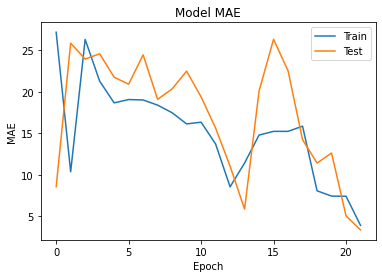

In [52]:
plt.plot(history.history["mae"])
plt.plot(history.history["val_mae"])
plt.title("Model MAE")
plt.ylabel("MAE")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper right")
plt.show()

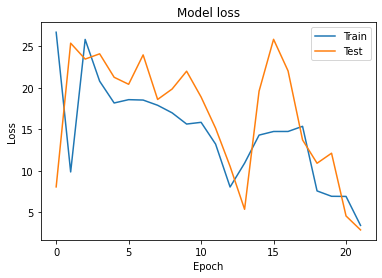

In [53]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper right")
plt.show()